In [18]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import math
import sys
import os
from Manifold_Analysis import Manifold_analysis
sys.path.append('../../../')
from algos.agents.dqn_agent import DQNAgent
from algos.models.dqn_cnn import DQNCnn
from algos.preprocessing.stack_frame import preprocess_frame, stack_frame


# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.metrics import pairwise_distances

from matplotlib.ticker import NullFormatter
from collections import OrderedDict
from functools import partial
from sklearn import manifold, datasets
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import cv2

In [2]:
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

## Init GPU or CPU

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Create Environment

In [4]:
#env = gym.make('SpaceInvaders-v0',render_mode='human')
env = gym.make('SpaceInvaders-v0')
env.seed(0)

def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

A.L.E: Arcade Learning Environment (version +978d2ce)
[Powered by Stella]


The size of frame is:  (210, 160, 3)
No. of Actions:  6
(160, 3)


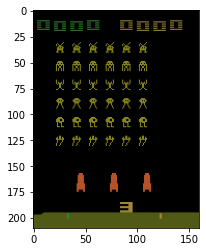

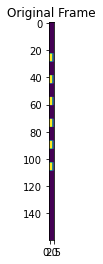

In [5]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
print(env.reset()[1:5][:][0].shape)
#print(env.reset()[1:5][:][0])
plt.figure()
plt.imshow(env.reset())
plt.figure()
plt.imshow(env.reset()[37,:,:])
plt.title('Original Frame')
plt.show()

## Create Agent

In [6]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 64        # Update batch size
LR = 0.0001            # learning rate 
TAU = 1e-3             # for soft update of target parameters
UPDATE_EVERY = 1       # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100         # Rate by which epsilon to be decayed

epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

start_epoch = 0
scores = []
scores_window = deque(maxlen=20)
length_trial = 500

In [9]:
agent_init = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)
agent_1000 = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)
agent_2000 = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)
agent_3000 = DQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DQNCnn)

Liste_agents = {
    "agent_init" : agent_init,
    "agent_1000" : agent_1000,
    "agent_2000" : agent_2000,
    "agent_3000" : agent_3000
}

Liste_agents = {
    "agent_dqn_2000" : agent_2000
 
}

## Load Agents corresponding to different part of the training

In [10]:
for a in Liste_agents.keys():
    if a != "agent_init":
        
        PATH = os.path.join(os.getcwd(),"Models_training_dqn_space_invader",a+ ".pt")
        print(PATH)
        checkpoint = torch.load(PATH , map_location=torch.device('cpu'))
        Liste_agents[a].policy_net.load_state_dict(checkpoint['modelA_state_dict'])
        Liste_agents[a].target_net.load_state_dict(checkpoint['modelB_state_dict'])
        Liste_agents[a].optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/Models_training_dqn_space_invader/agent_dqn_2000.pt


In [11]:
def position_agent(image):
    for i in range(image.shape[1]):
        a = np.sum(image[6,i,:],0) 
        if a == 232 : #color agent
            #position x y exacte : (191,i+3)
            return i+3
    return 7000
        
def position_alien(image):
    j = 0
    while True:
        for i in range(image.shape[1]):
            a = np.sum(image[j,i,:],0) 
            if a == 297 : ## color alien
                False
                return i+3
        if j<image.shape[0]-1:
            j +=1
        else:
            plt.figure()
            plt.imshow(image)
            return 7000



In [59]:
Names_hook = ["fc1","Conv_1","Conv_2","Conv_3"]
EPISODES = 1
Liste_activation = [[[[] for i in range(len(Names_hook))] for j in range(len( Liste_agents))] for episode in range(EPISODES)]
i = 0
Liste_position_agent = [[[] for j in range(len( Liste_agents))] for episode in range(EPISODES)]
Liste_action_agent = [[[] for j in range(len( Liste_agents))] for episode in range(EPISODES)]

Liste_position_alien = [[[] for j in range(len( Liste_agents))] for episode in range(EPISODES)]
parent_dir = os.getcwd()

try:
    os.mkdir("images_episode")
except OSError as error:
    pass

for episode in range(EPISODES):
    agent_number = 0
    for agent in Liste_agents.values():
        while i < length_trial:
            agent.registration()
            score = 0
            #print(Liste_activation[agent_number])
            
            Liste_activation[episode][agent_number] = [[] for i in range(len(Names_hook))]
            state = stack_frames(None, env.reset(), True)
            i = 0

            while True:
                #env.render()
                action = agent.act(state)

                for h in range(len(Names_hook)):
                    #print(torch.flatten(agent.activation[Names_hook[h]]).unsqueeze(0).size())
                    Liste_activation[episode][agent_number][h].append(torch.flatten(agent.activation[Names_hook[h]]))  # If concatenate list directly with Liste_activation[agent_number][h] += torch.flatten(agent.activation[Names_hook[h]]) takes much more time
        
                next_state, reward, done, _ = env.step(action)
                score += reward
                state = stack_frames(state, next_state, False)
                Liste_position_agent[episode][agent_number].append(position_agent(next_state[185:195,:,:]))
                Liste_position_alien[episode][agent_number].append(position_alien(next_state[35:150,:,:]))
                
                if position_alien(next_state[35:150,:,:]) == 7000:
                    plt.figure()
                    plt.imshow(next_state)
          

                Liste_action_agent[episode][agent_number].append(action)
                
                if i <500:
                    #path = "r"+"'"+os.path.join(parent_dir, "step_"+str(i)+"png")+"'"
                    path = os.path.join(parent_dir,"images_episode","step_"+str(i)+".jpg")
                    print(path)
                    cv2.imwrite(path,next_state)

                #if i%20==0:
                    #plt.figure()
                    
                    #plt.imshow(next_state[185:195,:,:])
                    #coordinates_agent = position_agent(next_state[185:195,:,:])
                    #print(next_state[0][:][:].shape)
                    #print(next_state.shape)
    
                i +=1
                if done:
                    print('\nEpisode :{} \tAgent number :{} \tFinal score: {:.2f} \tNumber of steps: {}'.format(episode,agent_number, score,i), end="")
        
                    break 
            env.close()


            agent.detach()
        i = 0   

        agent_number += 1
        

    

/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_0.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_1.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_2.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_3.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_4.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_5.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_6.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforc

/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_114.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_115.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_116.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_117.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_118.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_119.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_120.jpg
/Users/charlottebeylier/Documents/PhD/Ata

/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_174.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_175.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_176.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_177.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_178.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_179.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_180.jpg
/Users/charlottebeylier/Documents/PhD/Ata

/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_293.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_294.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_295.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_296.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_297.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_298.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_299.jpg
/Users/charlottebeylier/Documents/PhD/Ata

/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_391.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_392.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_393.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_394.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_395.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_396.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_397.jpg
/Users/charlottebeylier/Documents/PhD/Ata

/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_461.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_462.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_463.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_464.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_465.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_466.jpg
/Users/charlottebeylier/Documents/PhD/Atari1.0/Reinforcement-Learning_modif/cgames/02_space_invader/Analysis/images_episode/step_467.jpg
/Users/charlottebeylier/Documents/PhD/Ata

In [60]:
Distance = [Liste_position_agent[0][0][j] - Liste_position_alien[0][0][j] for j in range(len(Liste_position_agent[0][0]))]

In [61]:
length_trial = 200
analysis = Manifold_analysis(length_trial)


In [62]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation
import matplotlib.pyplot as plt    
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
        

def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)        

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  app.launch_new_instance()


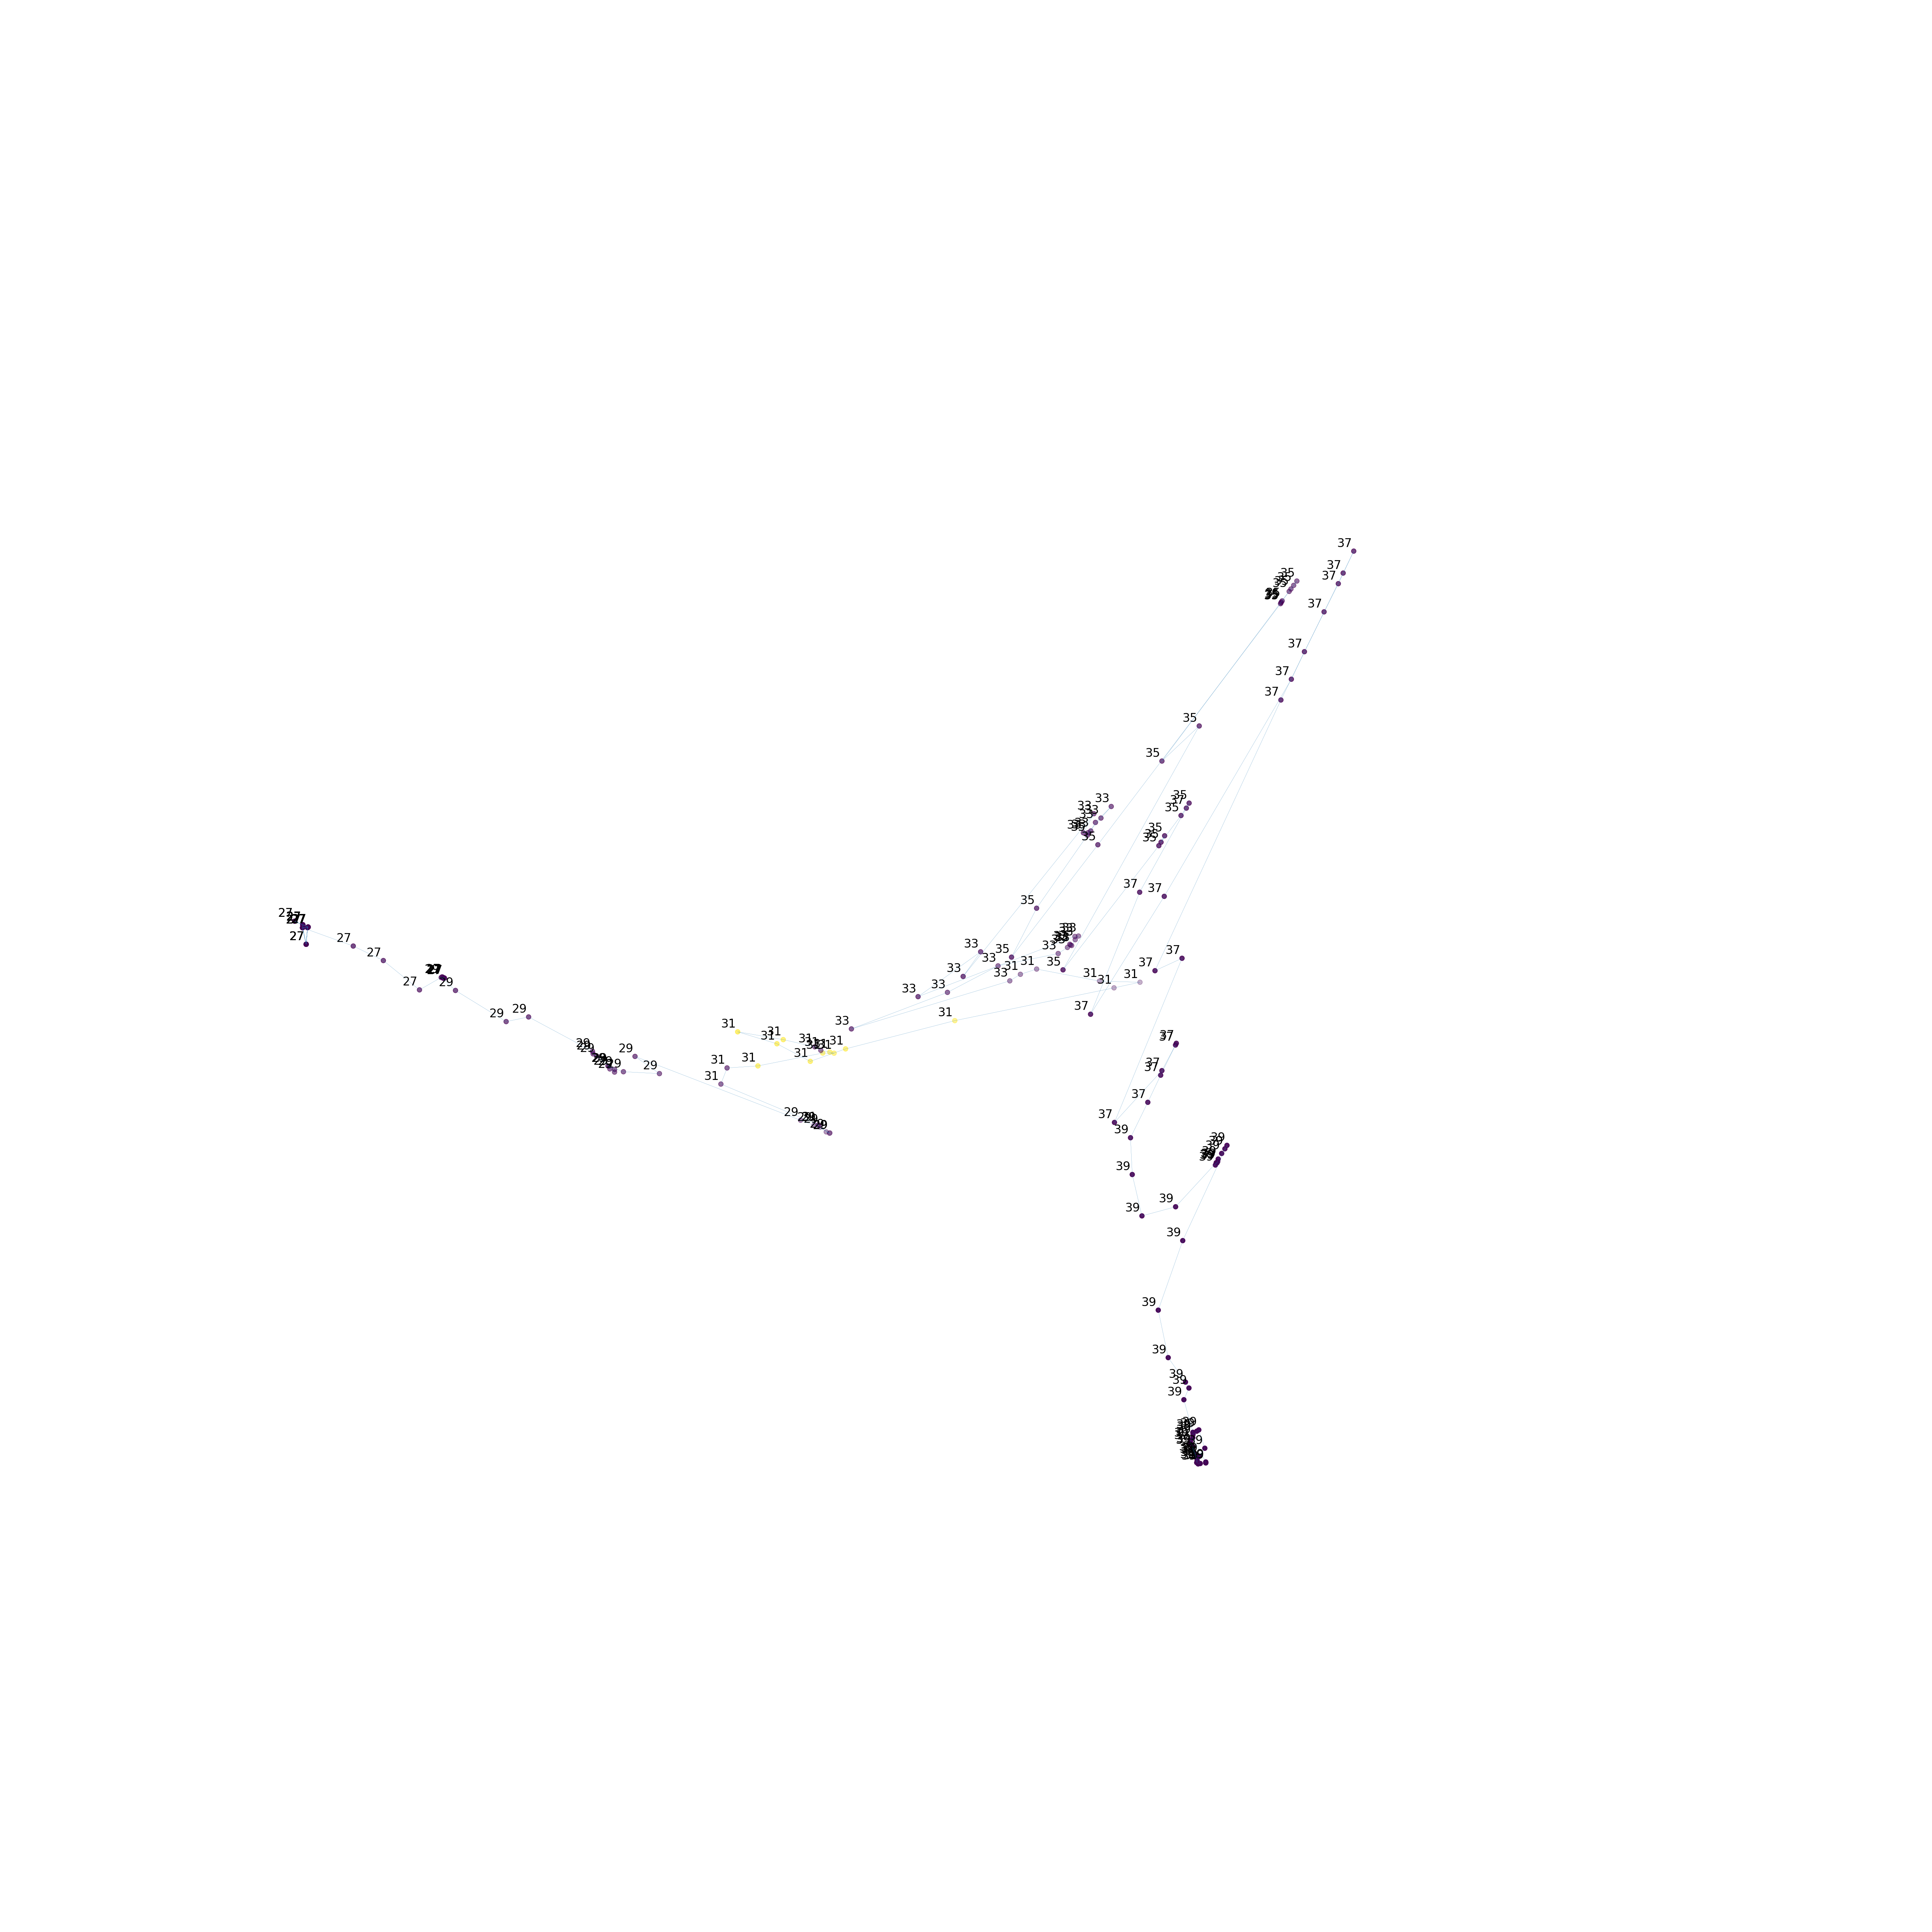

In [63]:
    
layer = 2
embedding = Isomap(n_neighbors=15,n_components=3)
i = 1

#fig = plt.figure(figsize=(40, 30))
#ax = fig.add_subplot(len(Liste_agents), len(Names_hook),i,projection='3d')
        #ax.axis("tight")
#ax.set_title("(agent %s) %s" % (agent_number, Names_hook[layer]))

activity_layer = analysis.prepro(Liste_activation[0][0][layer],length_trial)
X = embedding.fit_transform(activity_layer)
            #colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 7))
#ax.scatter3D(X[:, 0], X[:, 1], X[:, 2],label = episode)



xn = X[:, 0]
yn = X[:, 1]
zn = X[:, 2]

    
group = [Liste_action_agent[0][0][j] for j in range(len(activity_layer))]
group_label = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

#purple= 1 // blue= 2// cyan = 3 //green = 4 // yellow =5 


xyzn = list(zip(xn, yn, zn))
segments = [(xyzn[s], xyzn[s+1]) for s in range(len(X[:, 2])-1)]                

# create figure        
fig = plt.figure(figsize=(80, 60),dpi=120)
ax = plt.gca(projection='3d')

ax.set_axis_off()

# plot vertices
ax.scatter(xn,yn,zn, marker='o', c = group, s = 64)    
# plot edges
edge_col = Line3DCollection(segments, lw=0.2)
ax.add_collection3d(edge_col)
# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s=str(Liste_position_alien[0][0][j]), xyz=xyz_, fontsize=20, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')    



#plt.rcParams['animation.embed_limit'] = 2**128
#anim = animation.FuncAnimation(fig, animate, frames=200, interval=100)
#HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())



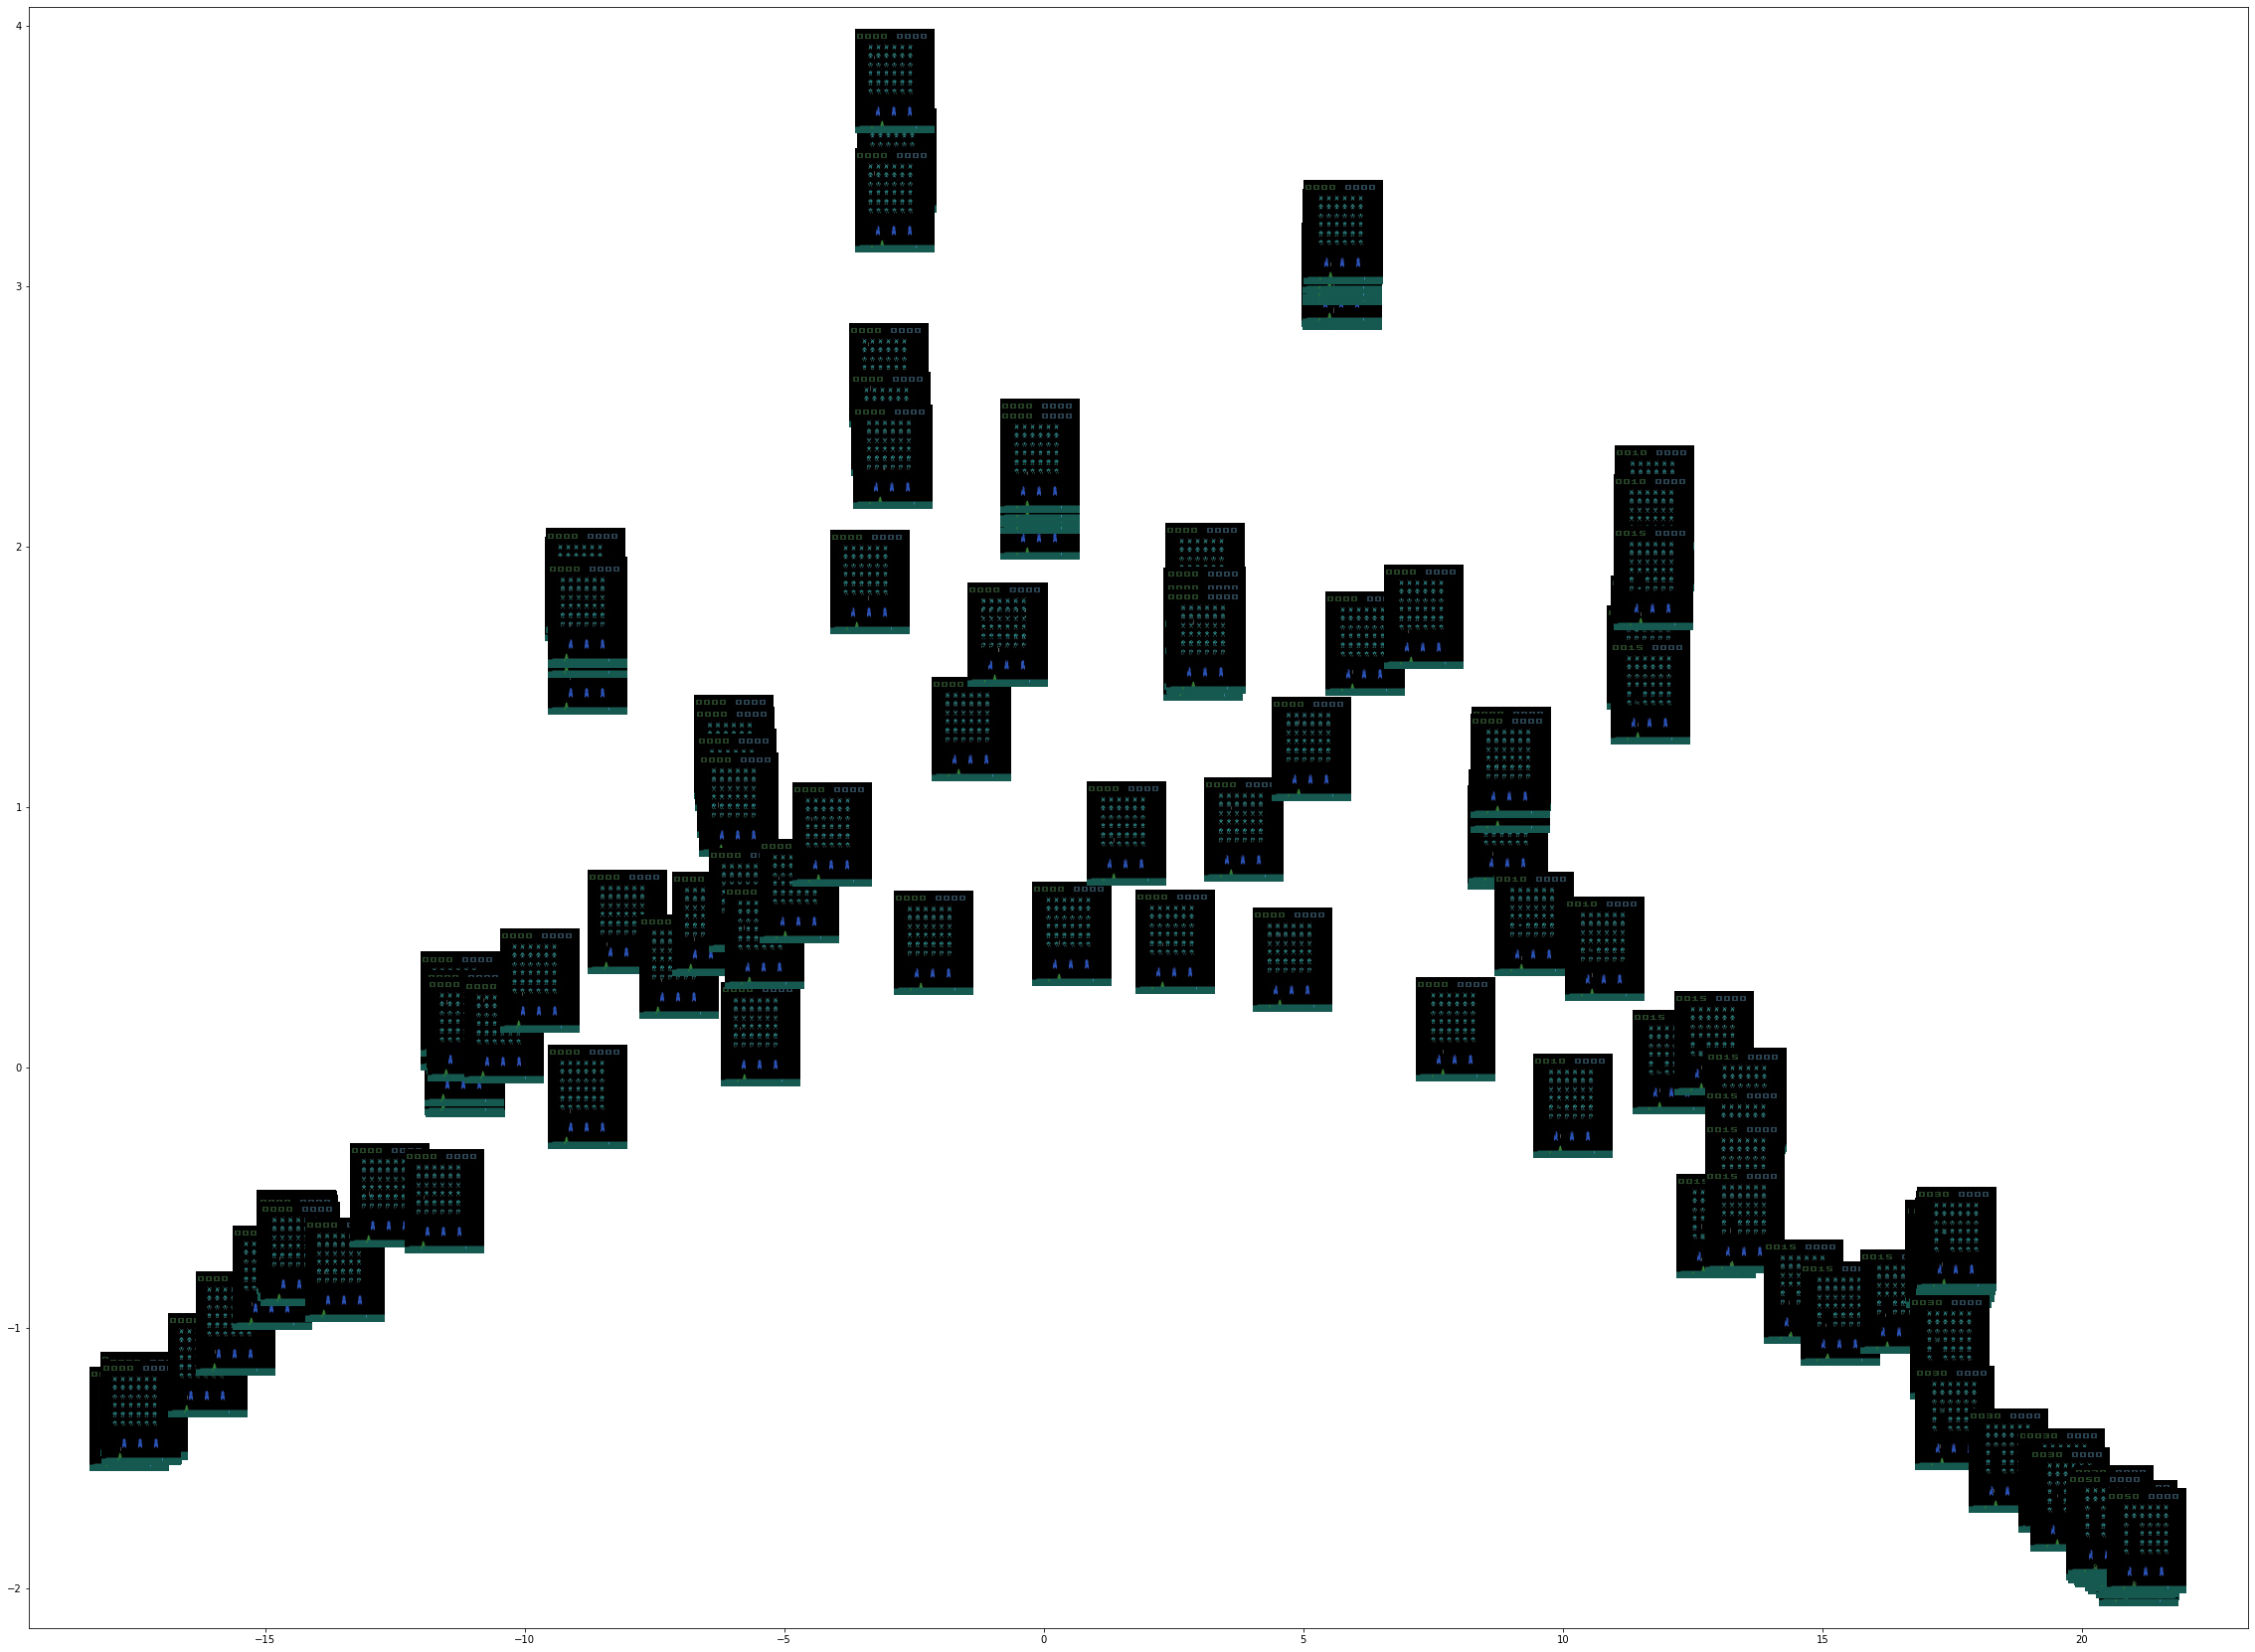

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data



def main(xn,yn,zn):
    fig, ax = plt.subplots(figsize=(40, 30))
    imscatter(xn, yn,zn,  zoom=0.5, ax=ax)
    ax.scatter(xn,yn,zn, marker='o')   
    plt.show()

def imscatter(x, y,z, ax=None, zoom=1):
    
    x, y,z = np.atleast_1d(x, y,z)
    artists = []
    i = 0
    for x0, y0, z0 in zip(x, y,z):
        image = os.path.join(parent_dir,"images_episode","step_"+str(i)+".jpg")
        if ax is None:
            ax = plt.gca()
        try:
            image = plt.imread(image)
        except TypeError:
            # Likely already an array.''..
            pass
        im = OffsetImage(image, zoom=zoom)
        
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        i+=1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main(X[:, 0],X[:, 1],X[:, 2])


def animate(frame):
    ax.view_init(30, frame/4)
    plt.pause(.001)
    
    return fig


    
layer = 1
embedding = Isomap(n_neighbors=15,n_components=2)
i = 1


activity_layer = analysis.prepro(Liste_activation[0][0][layer])
X = embedding.fit_transform(activity_layer)

fig = plt.figure(figsize=(40, 30),dpi=80)


plt.scatter(X[:, 0], X[:, 1],group)
plt.axis('equal');

text = Liste_position_agent[0][0]

for i in range(len(activity_layer)):
    plt.annotate(text[i], (X[i, 0], X[i, 1]))

## PCA

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/matplotlib/collections.py:980: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


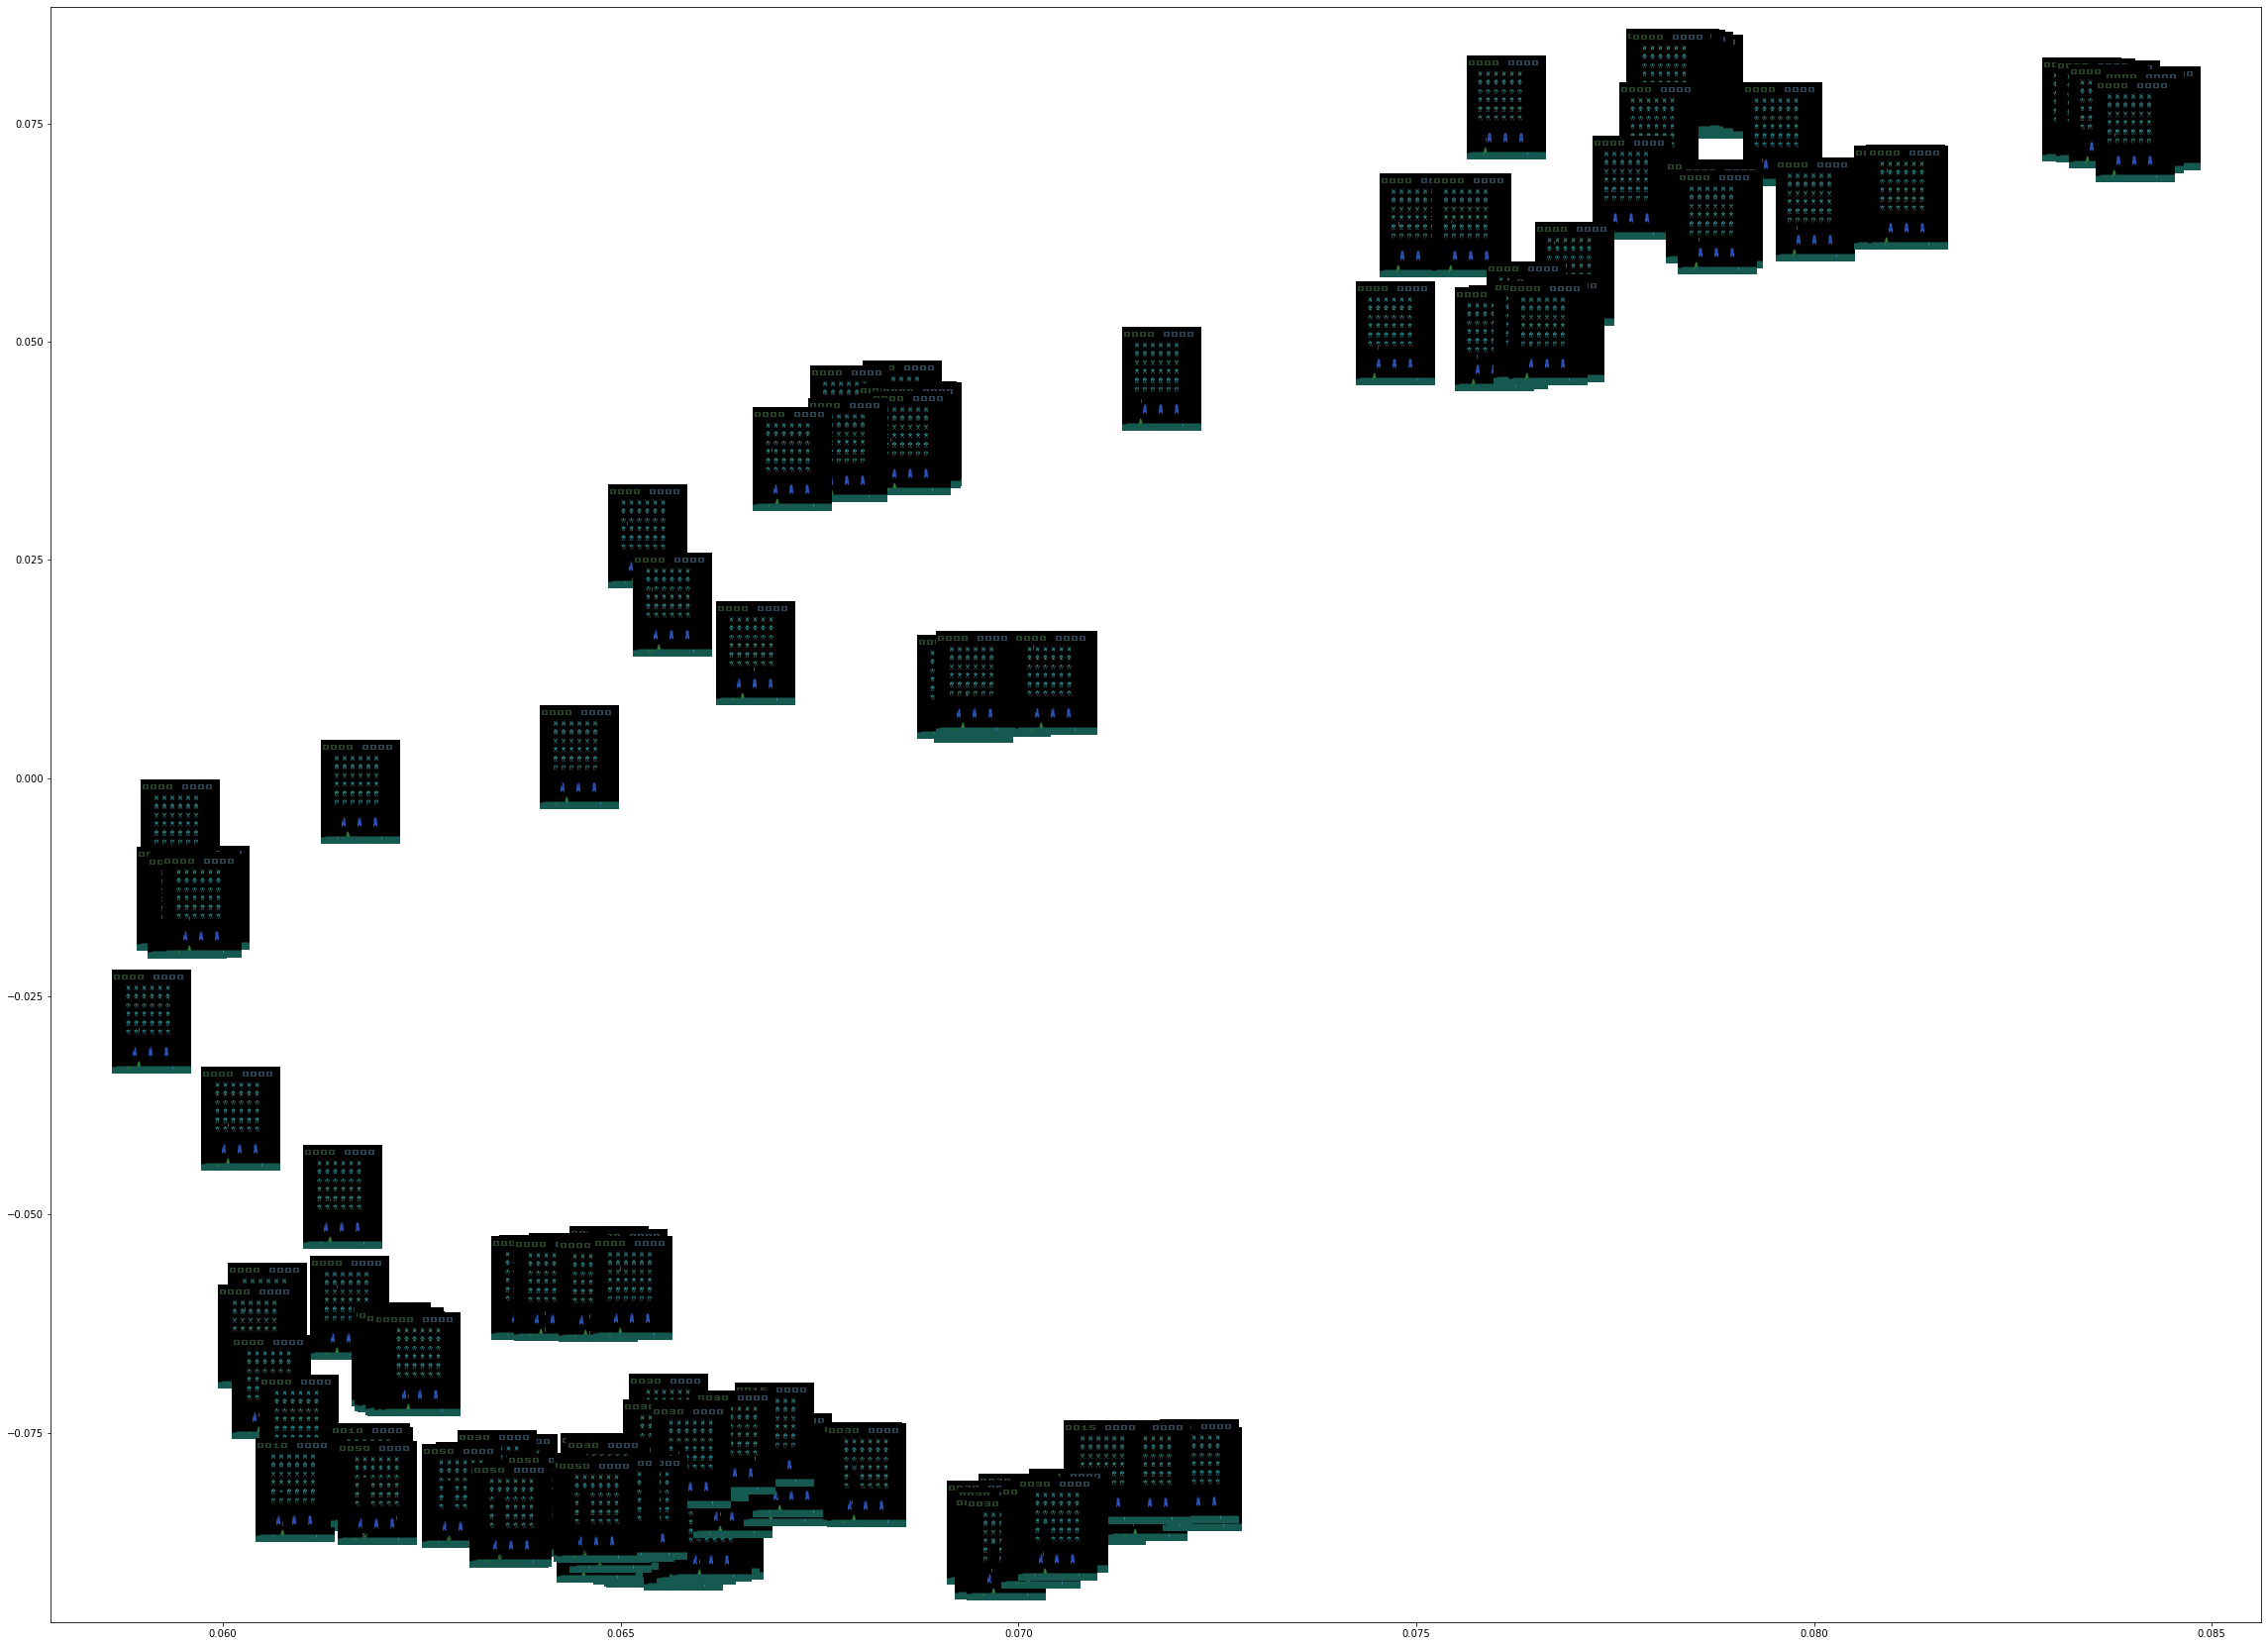

In [73]:
X = np.transpose(analysis.prepro(Liste_activation[0][0][layer],length_trial))
pca = PCA(n_components = 10) #we have 20 features
pca.fit(X)       

xn = pca.components_[0]
yn = pca.components_[1]
zn = pca.components_[2]

main(xn,yn,zn)

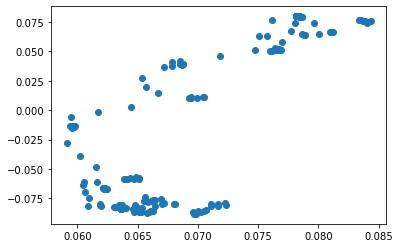

In [75]:
plt.figure()
plt.scatter(pca.components_[0],pca.components_[1])

/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  app.launch_new_instance()
/opt/anaconda3/envs/atari1.0/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  app.launch_new_instance()


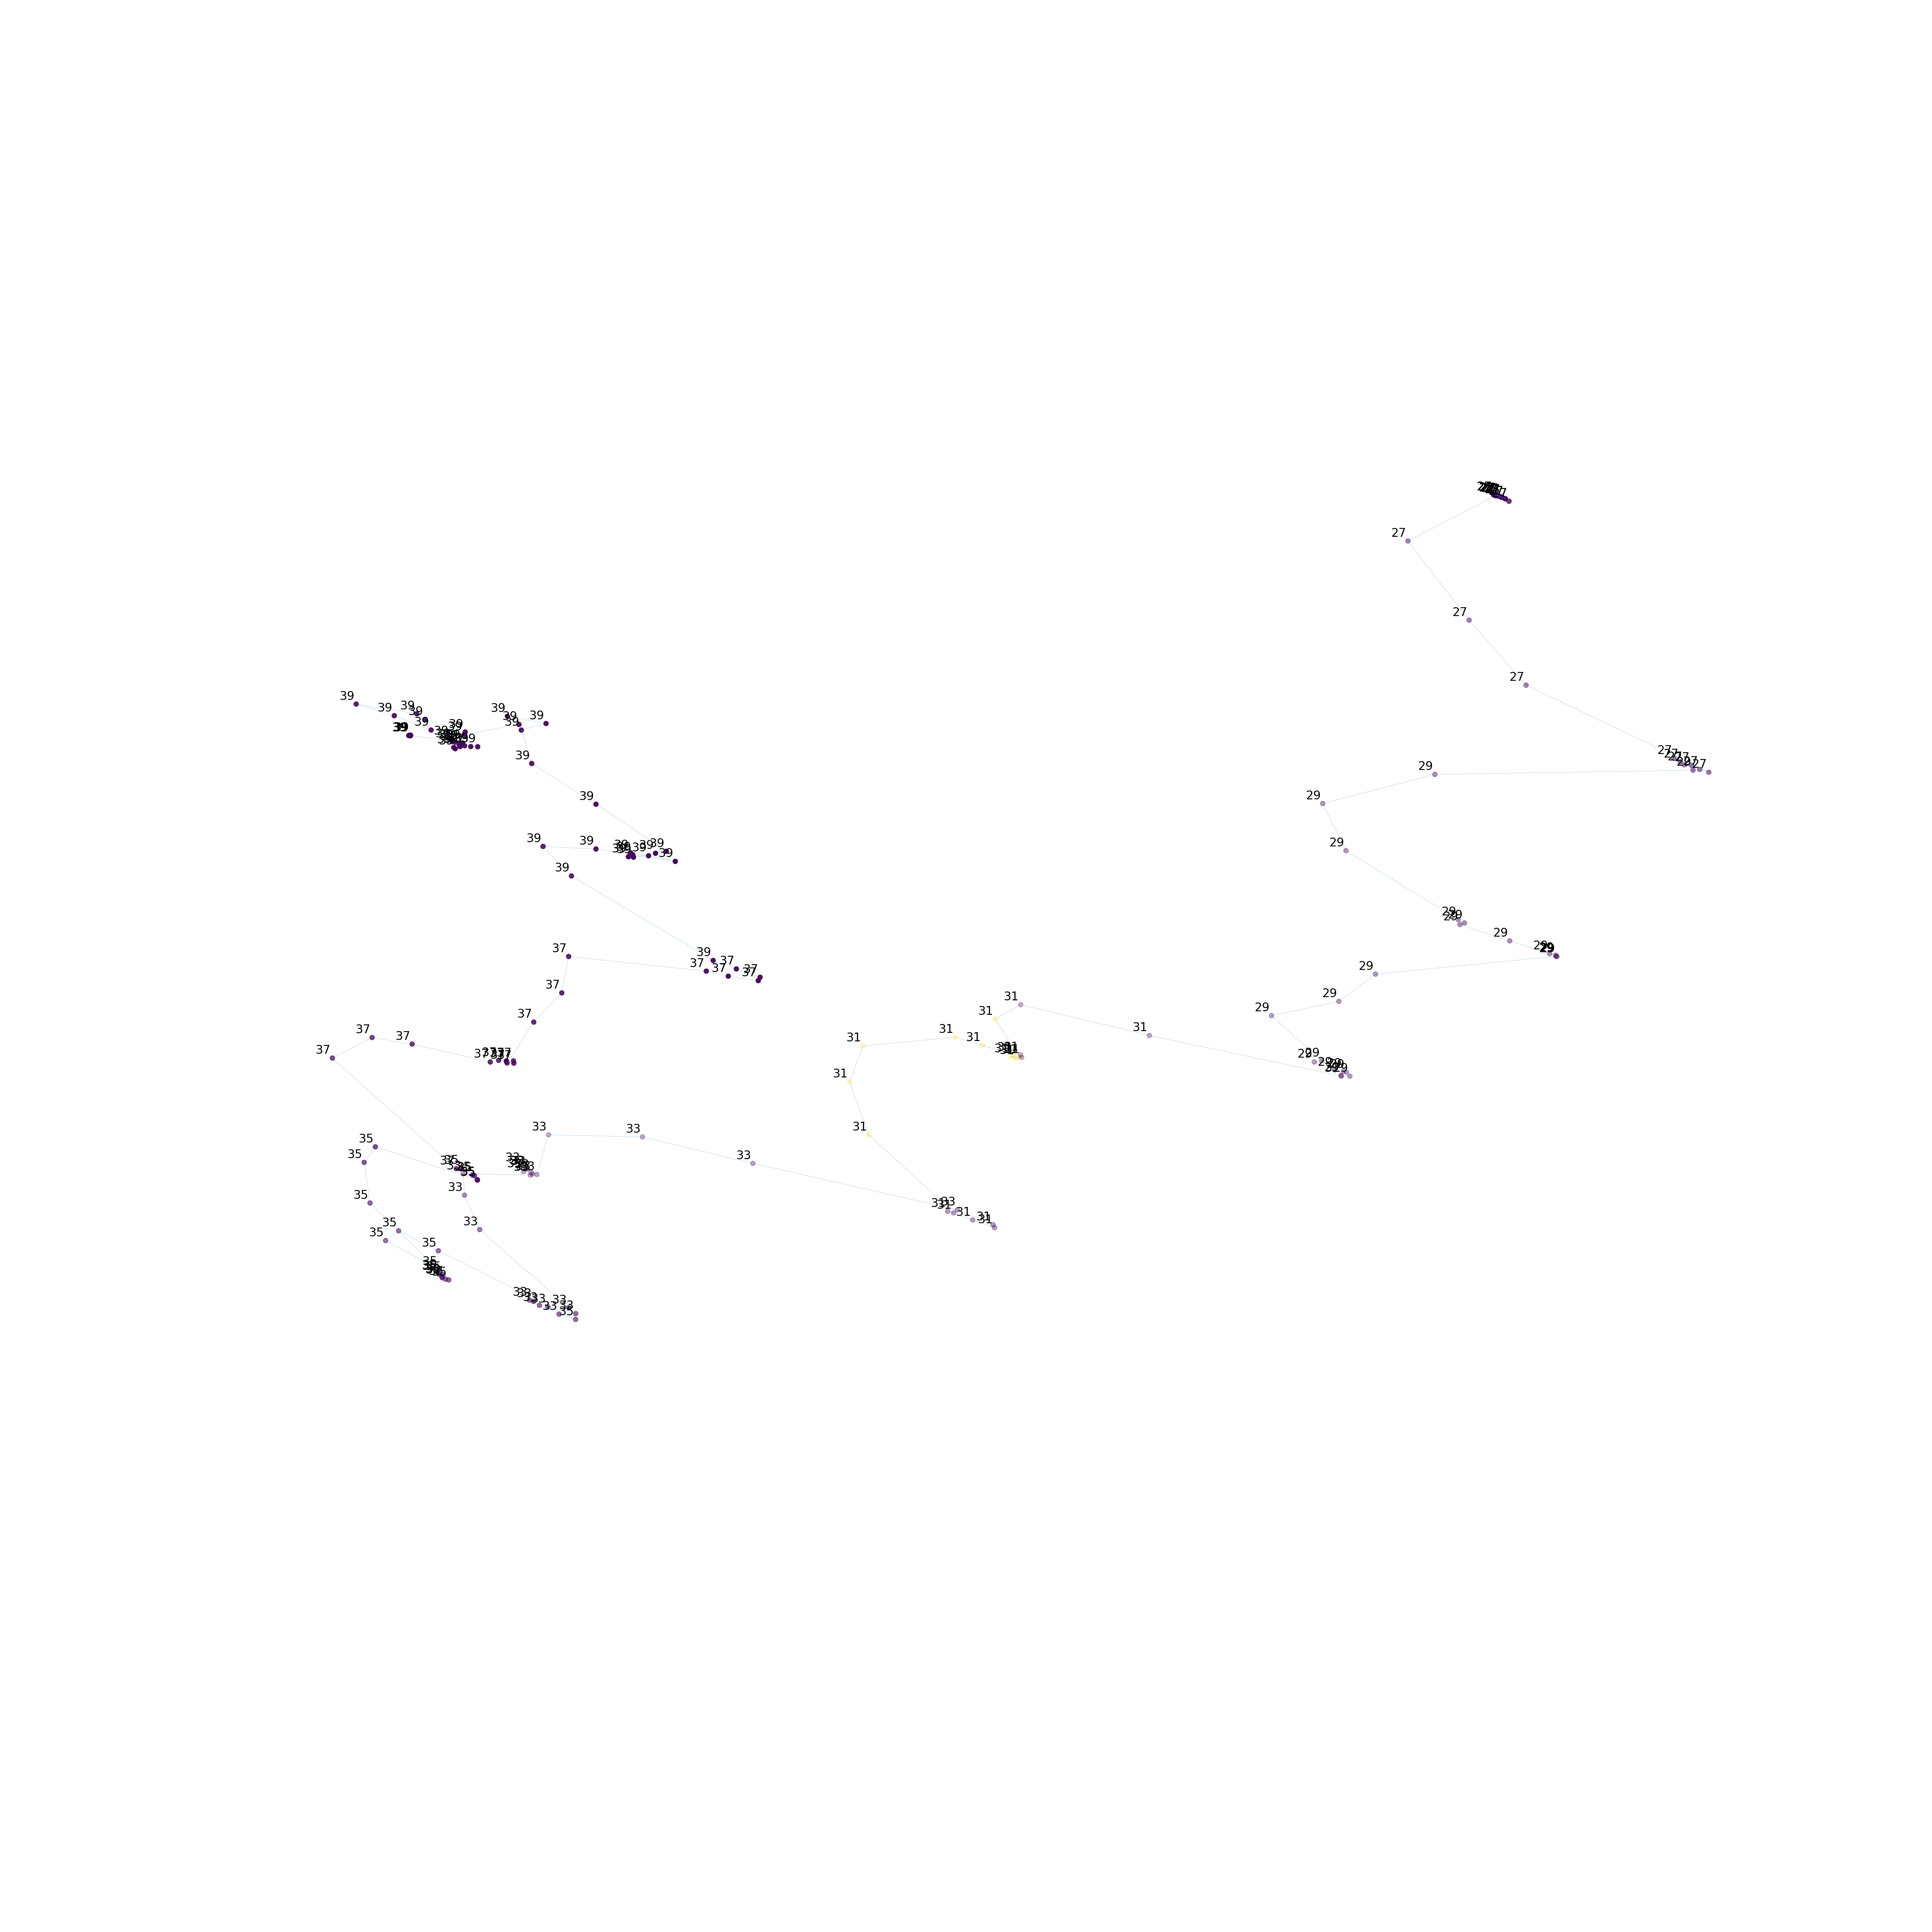

In [78]:

xn = pca.components_[0]
yn = pca.components_[1]
zn = pca.components_[2]
    
group = [Liste_action_agent[0][0][j] for j in range(len(activity_layer))]
group_label = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

#purple= 1 // blue= 2// cyan = 3 //green = 4 // yellow =5 


xyzn = list(zip(xn, yn, zn))
segments = [(xyzn[s], xyzn[s+1]) for s in range(len(pca.components_[0])-1)]                

# create figure        
fig = plt.figure(figsize=(80, 60),dpi=120)
ax = plt.gca(projection='3d')

ax.set_axis_off()

# plot vertices
ax.scatter(xn,yn,zn, marker='o', c = group, s = 64)    
# plot edges
edge_col = Line3DCollection(segments, lw=0.2)
ax.add_collection3d(edge_col)
# add vertices annotation.
for j, xyz_ in enumerate(xyzn): 
    annotate3D(ax, s=str(Liste_position_alien[0][0][j]), xyz=xyz_, fontsize=20, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')    



#plt.rcParams['animation.embed_limit'] = 2**128
#anim = animation.FuncAnimation(fig, animate, frames=200, interval=100)
#HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())


